# Определение возраста клиентов

Крупной сети гипермаркетов "Семерка" необходимо внедрить систему компьютерного зрения для работы с фотографиями покупателей.

В прикассовой зоне будет происходить фотофиксация с целями:
 - Контроль добросовестности продавцов при отпуске алкоголя;
 - Более эффективное продвижение товаров для покупателей конкретной возрастной группы.

Перед нами стоит задача построения модели, определяющей по фото примерный возраст человека. Мы распологаем набором фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем необходимые библиотеки и прочитаем файл с целевыми метками.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет.

In [4]:
labels[labels.duplicated()]

,file_name,real_age


Дубликатов нет.

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Средний возраст почти совпадает с медианным - разница в 2 года.

Посмотрим на графики.

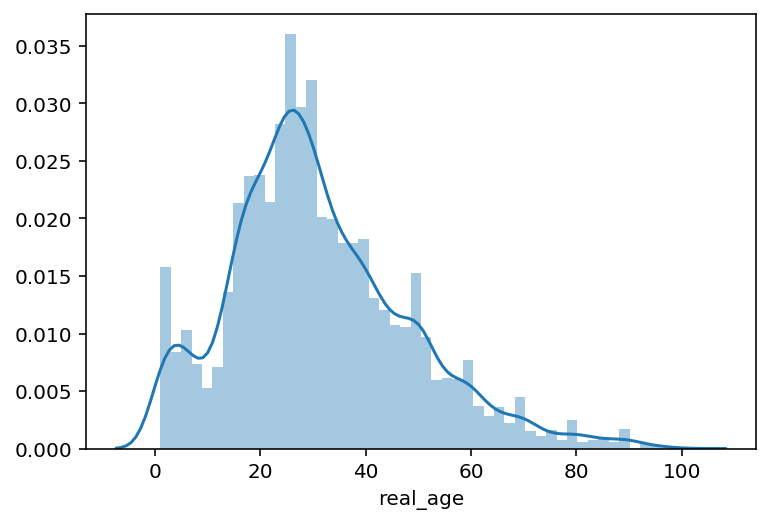

In [6]:
%config InlineBackend.figure_format = 'retina'

sns.distplot(labels['real_age'], bins=50);

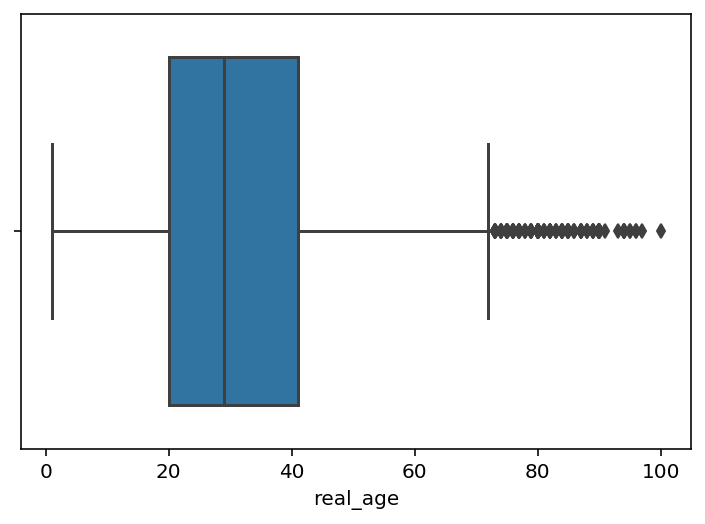

In [7]:
sns.boxplot(labels['real_age']);

Мы видим, что распределение немного смещено вправо, присутсвуют выбросы - к таким значениям относятся люди в возрасте за 70 лет.

Видна небольшая бимодальность распределения.

Также видно, что очень много младенцев.

Посмотрим на изображения

In [8]:
train_datagen = ImageDataGenerator(rescale= 1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col="file_name",
    y_col="real_age",
    
    target_size=(224, 224),
    
    
    batch_size=32,
    class_mode='raw',
    seed=2
)

Found 7591 validated image filenames.


In [9]:
features, target = next(train_datagen_flow)

In [10]:
features.shape

(32, 224, 224, 3)

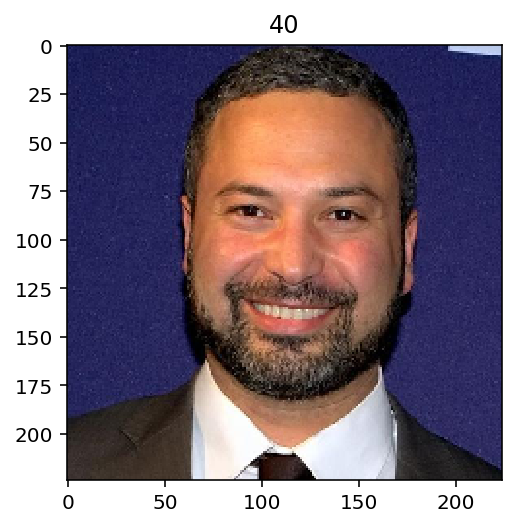

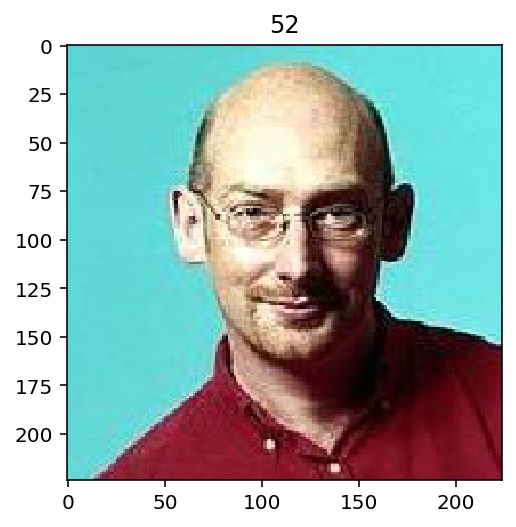

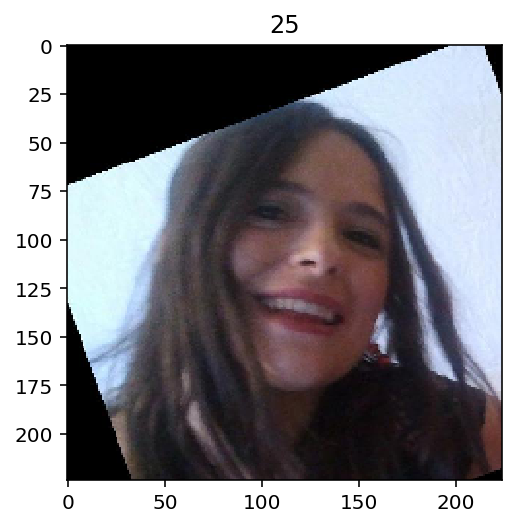

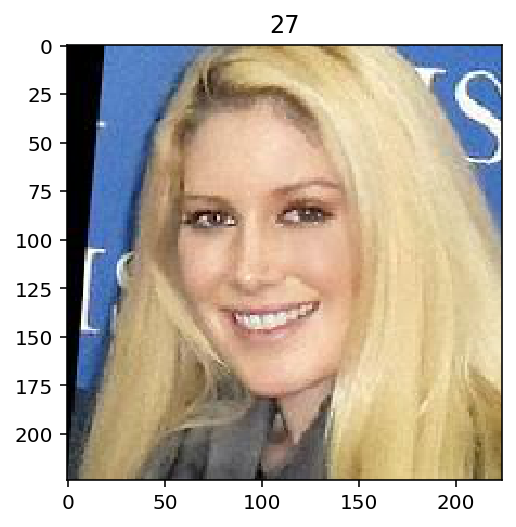

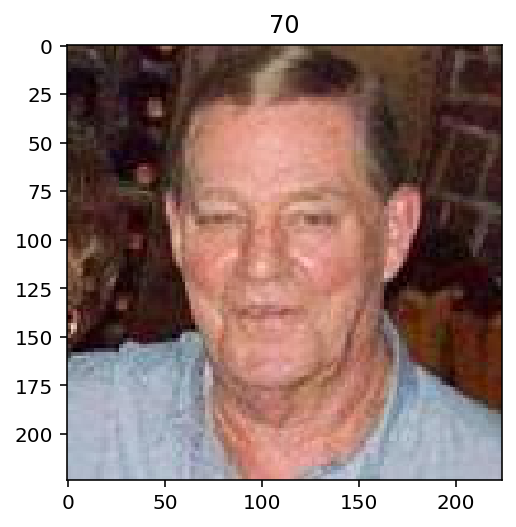

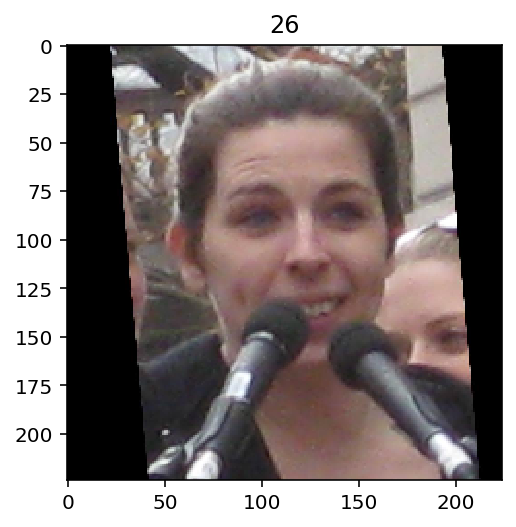

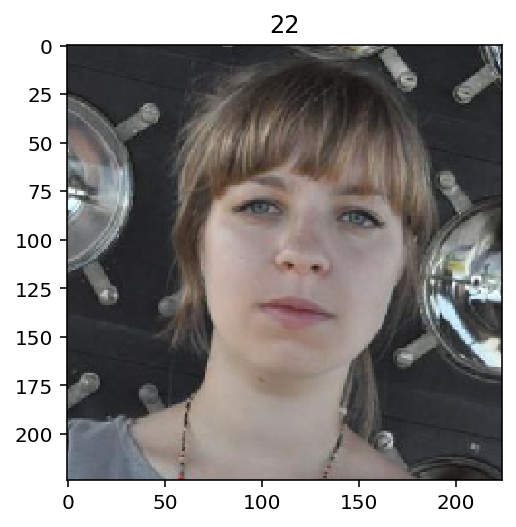

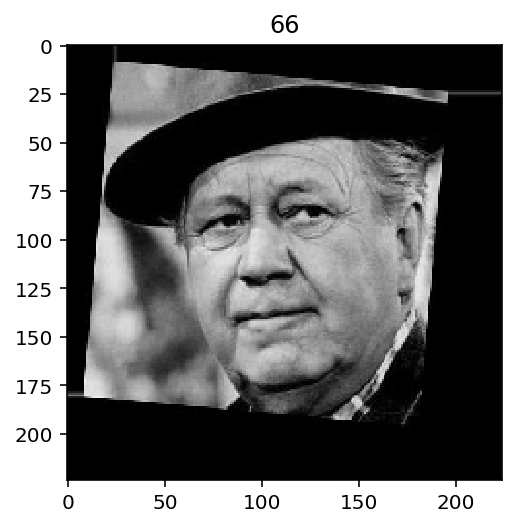

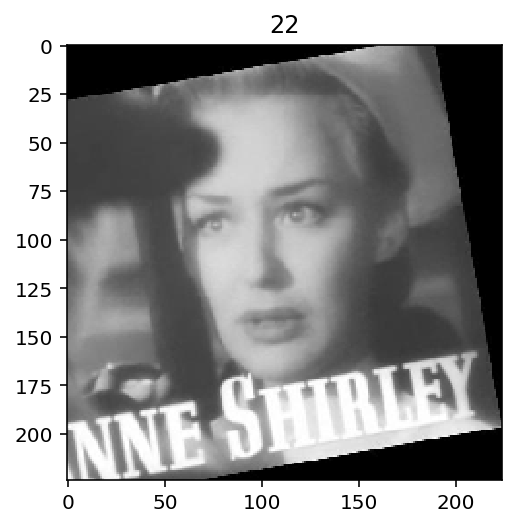

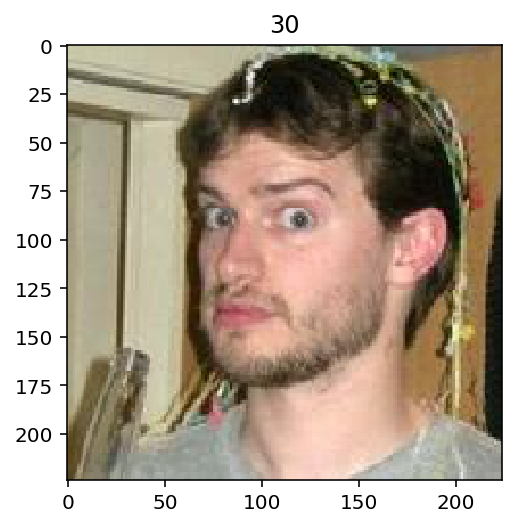

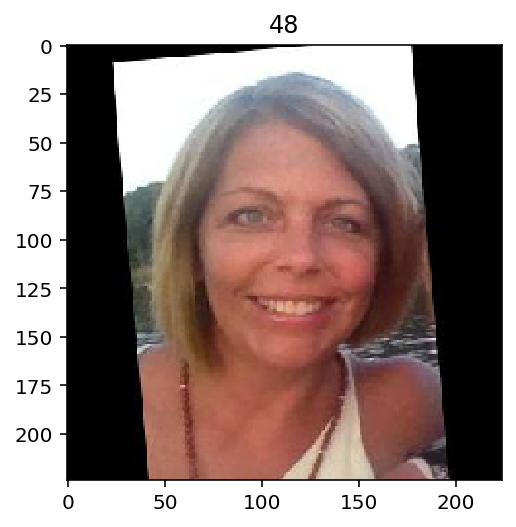

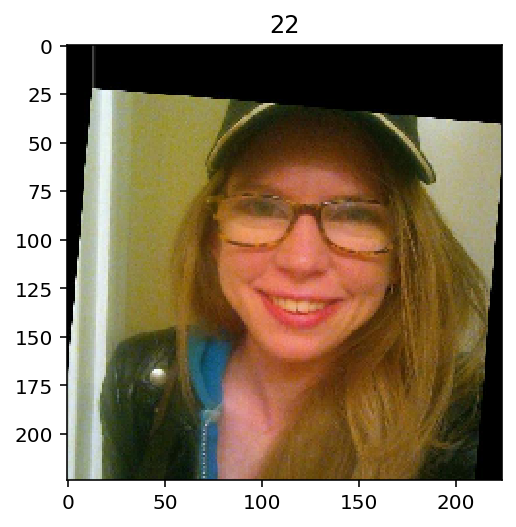

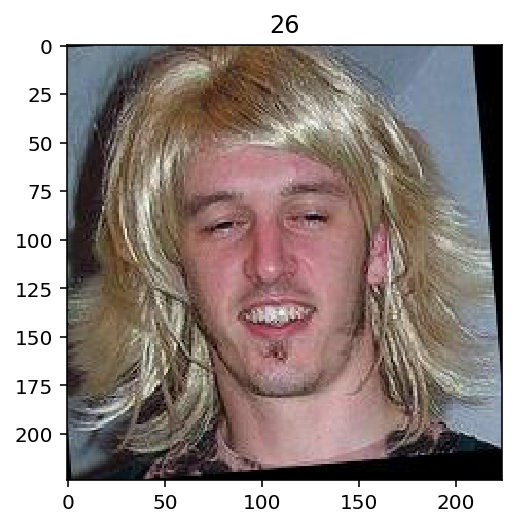

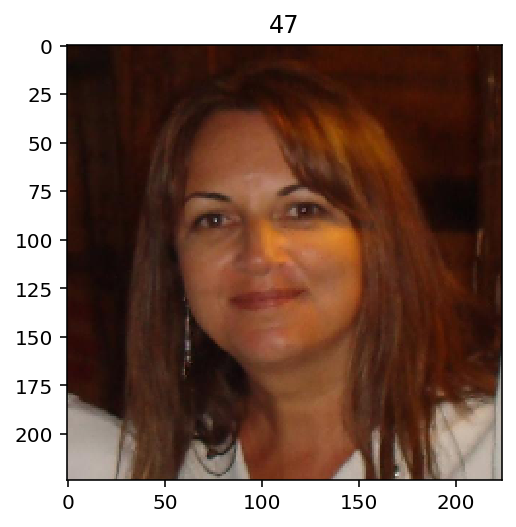

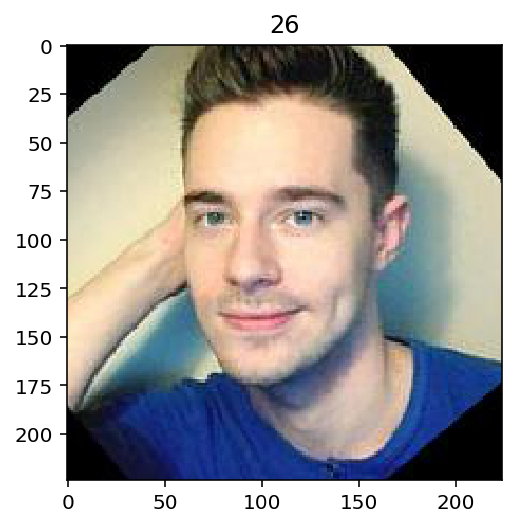

In [11]:
for age, image in zip(target[:15], features[:15]):
    plt.figure()
    plt.imshow(image)
    plt.title(age)

Заметим, что некоторые изображения повернуты. Поэтому при обучении модели применим аугментации - отражения по горизонтали.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

Сделаем отражения по горизонтали, отложим 25% под тестовую выборку.

Выберем архитектуру ResNet50, зададим веса imagenet, "верхушку" сделаем свою.

Алгоритм обучения - Adam, функция потерь - MSE, метрика - MAE.

Обучим модель на 7 эпохах.

```python
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + '/final_files',
    x_col="file_name",
    y_col="real_age",
    target_size=(224, 224), 
    batch_size=32,
    class_mode='raw',
    horizontal_flip=True,
    seed=2, 
    subset='training') 
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,    
    directory=path + '/final_files',
    x_col="file_name",
    y_col="real_age",    
    target_size=(224, 224),     
    batch_size=32,    
    class_mode='raw',
    seed=2, 
    subset='validation') 
    
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.001)
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

Продемонстрируем результат вывода.

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/7
2021-02-24 18:37:44.865973: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-02-24 18:37:49.224160: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 137s - loss: 234.0639 - mae: 11.5201 - val_loss: 685.8597 - val_mae: 21.2123
Epoch 2/7
178/178 - 43s - loss: 139.5870 - mae: 9.0355 - val_loss: 284.1865 - val_mae: 12.9687
Epoch 3/7
178/178 - 43s - loss: 112.2895 - mae: 8.1385 - val_loss: 332.1078 - val_mae: 13.4433
Epoch 4/7
178/178 - 42s - loss: 80.8517 - mae: 6.9505 - val_loss: 277.0692 - val_mae: 12.2937
Epoch 5/7
178/178 - 44s - loss: 57.9614 - mae: 5.8698 - val_loss: 117.5215 - val_mae: 8.2769
Epoch 6/7
178/178 - 43s - loss: 42.9441 - mae: 5.0779 - val_loss: 117.2188 - val_mae: 8.1345
Epoch 7/7
178/178 - 43s - loss: 26.0664 - mae: 3.9696 - val_loss: 92.9654 - val_mae: 7.2269
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 92.9654 - mae: 7.2269
Test MAE: 7.2269
```

## Анализ обученной модели

Из данных выше видно, что значение целевое значение MAE ниже 8 достигнуто, при этом мы не наблюдали переобучения.